# <center>Проект 3 </br>EDA + Feature Engineering. Соревнование на Kaggle</center>

## Оглавление:

* [1 Подготовка данных](#1-Подготовка-данных)
    * [1.1 Импорт библиотек](#1.1-Импорт-библиотек)
    * [1.2 Получение списка файлов для обработки](#1.2-Получение-списка-файлов-для-обработки)
    * [1.3 Определение констант](#1.3-Определение-констант)
    * [1.4 Подгрузка данных](#1.4-Подгрузка-данных)
    * [1.5 Объединение датасетов](#1.5-Объединение-датасетов)
* [2 Проверим, в каком виде представлены текстовые признаки](#2-Проверим,-в-каком-виде-представлены-текстовые-признаки)
* [3 Поиск дубликатов](#3-Поиск-дубликатов)
* [4 Определение признаков с пропусками данных](#4-Определение-признаков-с-пропусками-данных)
* [5 Преобразование признаков](#5-Преобразование-признаков)
    * [5.1 Обработка адреса отеля](#5.1-Обработка-адреса-отеля)
    * [5.2 Обработка координат отелей](#5.2-Обработка-координат-отелей)
    * [5.3 Обработка даты](#5.3-Обработка-даты)
    * [5.4 Обработка среднего балла отеля](#5.4-Обработка-среднего-балла-отеля)
    * [5.5 Обработка национальности человека, оставившего отзыв](#5.5-Обработка-национальности-человека,-оставившего-отзыв)
    * [5.6 Обработка отзывов](#5.6-Обработка-отзывов)
    * [5.7 Обработка количества слов в отзывах](#5.7-Обработка-количества-слов-в-отзывах)
    * [5.8 Обработка тегов](#5.8-Обработка-тегов)
    * [5.9 Обработка признака "days_since_review"](#5.9-Обработка-признака-days_since_review)
* [6 Определение неинформативных признаков](#6-Определение-неинформативных-признаков)
* [7 Отбор признаков](#7-Отбор-признаков)
* [8 Проверка на мультиколлинеарность](#8-Проверка-на-мультиколлинеарность)
    * [8.1 Анализ числовых признаков](#8.1-Анализ-числовых-признаков)
    * [8.2 Анализ категориальных признаков](#8.2-Анализ-категориальных-признаков)
    * [8.3 Оценка значимости признаков](#8.3-Оценка-значимости-признаков)

К сожалению, ссылки внутри ноутбука не работают на GitHub. Необходимо либо скачать ноутбук, либо перейти по [ссылке](https://nbviewer.org/github/DS-Makovetskiy/DS/blob/main/Project_3_EDA_and_Feature_Engineering/Project_3_EDA_and_Feature_Engineering.ipynb).

**Ссылки на файлы с данными**  
[hotels_test](https://drive.google.com/file/d/1za078vGgoWGzGTkBpTCEGubu-gI0UFOY/view?usp=sharing)  
[hotels_train](https://drive.google.com/file/d/1z_YHnmxAvNS7X8HY3Td7rJPeYHJt67kr/view?usp=sharing)  
[submission](https://drive.google.com/file/d/1zaCyhhCVR1vGRCHKF8RVdK9mzsWSwI7s/view?usp=sharing)

## 1 Подготовка данных

### 1.1 Импорт библиотек

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import shapiro, spearmanr, pearsonr
from IPython.display import display

# Кодирование признаков
import category_encoders as ce

# Визуализация признаков
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Обработка естественного языка
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Отображение индикатора прогресса
from tqdm.auto import tqdm
tqdm.pandas()

# Машинное обучение
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import f_classif, chi2

# Получение координат по адресу
from geopy.geocoders import Nominatim
from functools import partial

from data_preprocessing import search_null_values
from data_preprocessing import clean_tags
from data_preprocessing import get_number_of_nights

### 1.2 Получение списка файлов для обработки

In [2]:
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/hotels_test.csv
data/hotels_train.csv
data/submission.csv


### 1.3 Определение констант

In [3]:
RANDOM_SEED = 42
DATA_DIR = 'data/'

### 1.4 Подгрузка данных

In [4]:
# Датасет для обучения
df_train = pd.read_csv(DATA_DIR + 'hotels_train.csv')

# Датасет для предсказания
df_test  = pd.read_csv(DATA_DIR + 'hotels_test.csv')

# Самбмишн
sample_submission = pd.read_csv(DATA_DIR + 'submission.csv')

**Датасет для обучения**

In [5]:
display(df_train.head(2))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


**Датасет для предсказания**

In [6]:
display(df_test.head(2))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


**Самбмишн**

In [7]:
display(sample_submission.head(2))

,reviewer_score,id
0,1,488440
1,10,274649


### 1.5 Объединение датасетов

Для корректной обработки признаков, объединяем трейн и тест в один датасет

In [8]:
df_train['sample']        = 1   # помечаем Train
df_test['sample']         = 0   # помечаем Test
df_test['reviewer_score'] = 0   # пока что заполняем нулями

data = pd.concat([df_test, df_train], ignore_index=True, sort=False)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [10]:
display(data.head(2))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0


[&#8679; к оглавлению](#Оглавление:)

## 2 Проверим, в каком виде представлены текстовые признаки

Создадим списк признаков, с типом Object

In [11]:
object_columns = [s for s in data.columns if data[s].dtypes == 'object']

print(f'Признаки, с типом Object: {object_columns}')

Признаки, с типом Object: ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']


Посмотрим на первую запись каждого признака

In [12]:
for col in object_columns:
    print(col)
    print(f'|{data[col][0]}|\n')

hotel_address
|Via Senigallia 6 20161 Milan Italy|

review_date
|7/21/2017|

hotel_name
|Hotel Da Vinci|

reviewer_nationality
| United Kingdom |

negative_review
| Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices |

positive_review
| Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again |

tags
|[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']|

days_since_review
|13 days|



В признаках **reviewer_nationality**, **negative_review**, **positive_review** присутсвуют лишние пробелы в начале и конце строки, необходимо их удалить.  
Признак **tags** так же имеет некорректное форматирование, его преобразуем в разделе обработки тегов.

In [13]:
# очистка данных от лишних пробелов
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())
data['negative_review']      = data['negative_review'].apply(lambda x: x.strip())
data['positive_review']      = data['positive_review'].apply(lambda x: x.strip())

[&#8679; к оглавлению](#Оглавление:)

## 3 Поиск дубликатов

Поскольку по условию соревнования нельзя удалять строки, поэтому создадим признак **"duplicates"**, в котором будут помечены дублирующиеся записи

In [14]:
dupl_columns = list(data.columns)  

mask = data.duplicated(subset=dupl_columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 336


In [15]:
# создание признака с пометкой о дублировании записи
data['duplicates'] = data.duplicated(subset=dupl_columns)

# приведение признака к числовому виду
data['duplicates'] = data['duplicates'].apply(lambda x: 1 if x else 0)

In [16]:
data['duplicates'].value_counts()

duplicates
0    515402
1       336
Name: count, dtype: int64

[&#8679; к оглавлению](#Оглавление:)

## 4 Определение признаков с пропусками данных

Посмотрим на количество пропусков в данных

In [17]:
search_null_values(data)

Количество пропусков в признаках:


lat    3268
lng    3268
dtype: int64

Пропуски присутствуют только в двух признаках **"lat"** и **"lng"**. Посмотрим к каким отелям они относятся.

In [18]:
display(data[data['lat'].isna()][['hotel_address', 'hotel_name', 
                                  'lat', 'lng']].head(3))

,hotel_address,hotel_name,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,Hotel Atlanta,NaN,NaN
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,Hotel Atlanta,NaN,NaN
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,City Hotel Deutschmeister,NaN,NaN


Попробуем извлечь из адреса отеля название страны и города, для того, чтобы заменить недостающие координаты отелей, координатами городов.

[&#8679; к оглавлению](#Оглавление:)

## 5 Преобразование признаков

### 5.1 Обработка адреса отеля

Извлекаем из адреса отеля название страны и города

In [19]:
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['city']    = data['hotel_address'].apply(lambda x: x.split(' ')[-2])

display(data[['hotel_address', 'country', 'city']].head(3))

,hotel_address,country,city
0,Via Senigallia 6 20161 Milan Italy,Italy,Milan
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,Netherlands,Amsterdam
2,Mallorca 251 Eixample 08008 Barcelona Spain,Spain,Barcelona


Как видно из датасета, страна **"United Kingdom"** и город **"London"** извлечены некорректно, исправим это

In [20]:
data['country'] = data['country'].apply(lambda x:'United Kingdom' if x == 'Kingdom' else x)
data['city']    = data['city'].apply(lambda x:'London' if x == 'United' else x)

display(data[['hotel_address', 'country', 'city']].head(3))

,hotel_address,country,city
0,Via Senigallia 6 20161 Milan Italy,Italy,Milan
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,Netherlands,Amsterdam
2,Mallorca 251 Eixample 08008 Barcelona Spain,Spain,Barcelona


Страна и город заменены корректно, можно добавить признак **"hotel_address"** в список для удаления, который будем пополнять по ходу обработки данных.

In [21]:
drop_list = list()

drop_list.append('hotel_address')

**Посмотрим, какой стране ставят наименьшую и наибольшую среднюю оценку**

In [22]:
# возьмем данные целевого признака из train выборки
reviewer_score_country = data[data['sample']==1].pivot_table(
    values  = 'reviewer_score', 
    index   = 'country', 
    aggfunc = 'mean'
)

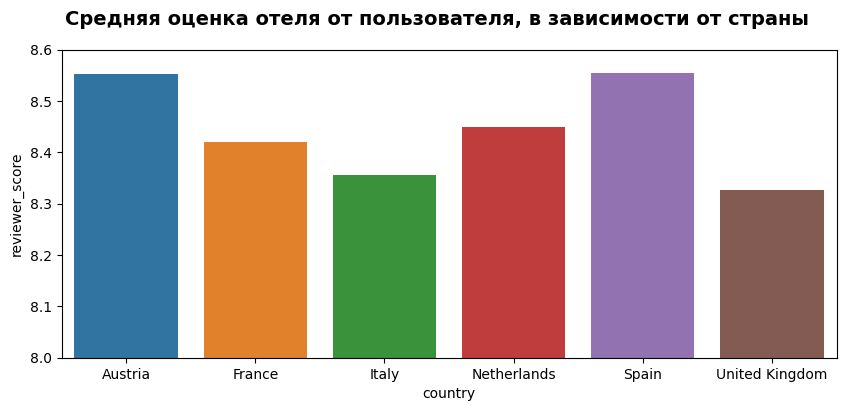

In [23]:
plt.figure(figsize=(10, 4))
barplot_m = sns.barplot(
    data = reviewer_score_country,
    x   = reviewer_score_country.index, 
    y   = 'reviewer_score',
    hue = 'country')
plt.suptitle(
    'Средняя оценка отеля от пользователя, в зависимости от страны', 
    fontweight='bold', 
    fontsize=14)

# Ограничим диапазон оценки для большей наглядности
plt.ylim(8, 8.6);

В среднем, пользователи чаще ставят более высокие оценки Австрии и Испании, по всей видимости из-за более высокого уровня сервиса и субъективной красоты природы и городов. Более низкая оценка Англии может быть обусловлена особенностями климата.

**Посмотрим на количество стран и городов в датасете**

In [24]:
print(f'Количество стран: {data["country"].nunique()}')
print(f'Количество городов: {data["city"].nunique()}')

Количество стран: 6
Количество городов: 6


Поскольку стран и городов немного, закодируем каждый город и страну в отдельный признак

In [25]:
country_list = list(data["country"].unique())

for country in country_list:
    country_col       = country.lower().replace(' ', '_')
    data[country_col] = data["country"].apply(lambda x: 1 if country == x else 0)


city_list = list(data["city"].unique())

for city in city_list:
    city_col       = city.lower().replace(' ', '_')
    data[city_col] = data["city"].apply(lambda x: 1 if city == x else 0)

In [26]:
country_city_df = pd.concat(
    [data[['country', 'city']].loc[:4], data.loc[:4, 'italy':]], 
    axis=1)

display(country_city_df)

,country,city,italy,netherlands,spain,united_kingdom,france,austria,milan,amsterdam,barcelona,london,paris,vienna
0,Italy,Milan,1,0,0,0,0,0,1,0,0,0,0,0
1,Netherlands,Amsterdam,0,1,0,0,0,0,0,1,0,0,0,0
2,Spain,Barcelona,0,0,1,0,0,0,0,0,1,0,0,0
3,Italy,Milan,1,0,0,0,0,0,1,0,0,0,0,0
4,Netherlands,Amsterdam,0,1,0,0,0,0,0,1,0,0,0,0


Данные извлечены корректно, добавим признаки **country** и **city** в список для удаления

In [27]:
drop_list.extend(['country', 'city'])

**Добавим признак населения страны и города.**

In [28]:
# население стран в 2017 году
country_population = {
    'United Kingdom': 66060000, 
    'Netherlands':    17130000, 
    'France':         66920000,
    'Spain':          46590000, 
    'Italy':          60540000, 
    'Austria':        8798000
}

data['country_population'] = data['country'].map(country_population)


# население городов в 2017 году
сity_population = {
    'Paris':     2188000, 
    'London':    8797000, 
    'Milan':     1352000,
    'Vienna':    1868000, 
    'Barcelona': 1621000, 
    'Amsterdam': 905000
}

data['сity_population'] = data['city'].map(сity_population)

# посчитаем разницу между населением города и страны
data['population_diff'] = data['сity_population'] / data['country_population']

In [29]:
display(data[['country_population', 'сity_population', 'population_diff']].head())

,country_population,сity_population,population_diff
0,60540000,1352000,0.022332
1,17130000,905000,0.052831
2,46590000,1621000,0.034793
3,60540000,1352000,0.022332
4,17130000,905000,0.052831


### 5.2 Обработка координат отелей

**Посмотрим, в каких городах отсутствуют координаты отелей**

In [30]:
missing_coordinates = data[(data['lat'].isna()) & (data['lng'].isna())]['city']

display(missing_coordinates.value_counts())

city
Vienna       2679
Paris         382
Barcelona     207
Name: count, dtype: int64

Сохраним названия городов без координат в список

In [31]:
hotel_names = list(missing_coordinates.unique())

Выполним поиск координат городов из списка, при помощи библиотеки **geopy**

In [32]:
geolocator = Nominatim(user_agent='USER_AGENT')

for name in hotel_names:
    geocode  = partial(geolocator.geocode, language="en")
    location = geolocator.geocode(name)
    print(str(geocode(name)).split(',')[0])
    
    # Так как координаты в датасете имеют длину в 9-10 символов, проводим
    # проверку на длину полученных координат и ограничиваем 10-ю символами
    if len(str(location.latitude)) > 10 or len(str(location.longitude)) > 10:
        lat = float(str(location.latitude)[:10])
        lng = float(str(location.longitude)[:10])
    else:
        lat = location.latitude
        lng = location.longitude
    
    # Замена пустых значений на координаты текущего города.
    data['lat'] = np.where(((data['lat'].isna()) & (data['city'] == name)), lat, data['lat']).astype('float64')
    data['lng'] = np.where(((data['lng'].isna()) & (data['city'] == name)), lng, data['lng']).astype('float64')
    print(lat, lng)

Vienna
48.2083537 16.3725042
Paris
48.8534951 2.3483915
Barcelona
41.3828939 2.1774322


Повторно проверяем датасет на наличие пропусков

In [33]:
search_null_values(data)

Пропусков не обнаружено


### 5.3 Обработка даты

**Приведение признака к формату *datetime***

In [34]:
data['review_date'] = pd.to_datetime(data['review_date'], yearfirst=False)

# создадим признак месяца
data['review_month'] = data['review_date'].dt.month.astype('int')

display(data[['review_date', 'review_month']].head(3))

,review_date,review_month
0,2017-07-21,7
1,2016-12-12,12
2,2015-11-26,11


Данные извлечены корректно, можно добавить признак **"review_date"** в список для удаления

In [35]:
drop_list.append('review_date')

**Посмотрим, на месяцы с наибольшей и наименьшей средней оценкой пользователей**

Возьмем данные целевого признака из train выборки для построения сводной таблицы со средним значением отзывов пользователей для каждого месяца

In [36]:
reviewer_score_month = data[data['sample'] == 1].pivot_table(
    values  = 'reviewer_score', 
    index   = 'review_month', 
    aggfunc = 'mean').reset_index()

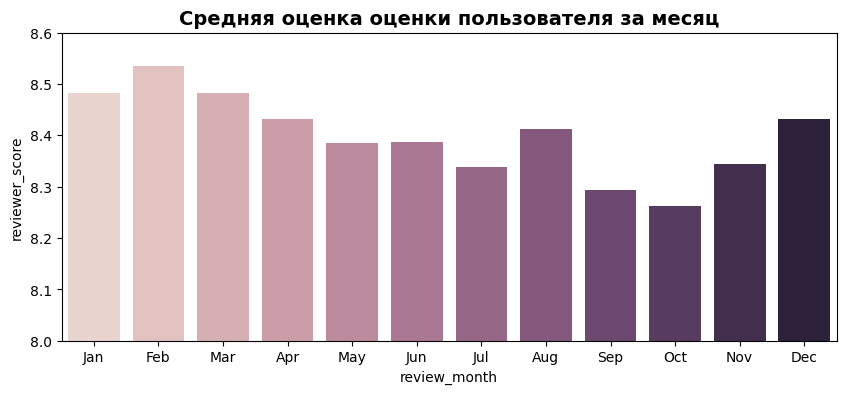

In [37]:
plt.figure(figsize=(10, 4))

barplot = sns.barplot(
    data = reviewer_score_month,
    x    = 'review_month', 
    y    = 'reviewer_score',
    hue  = 'review_month'
)
barplot.set_title('Средняя оценка оценки пользователя за месяц', fontweight='bold', fontsize=14)

x_labels = ['Jan', 'Feb', 'Mar', 'Apr', 
            'May', 'Jun', 'Jul', 'Aug', 
            'Sep', 'Oct', 'Nov', 'Dec']
barplot.set_xticks(range(len(x_labels)))
barplot.set_xticklabels(x_labels)
barplot.legend().set_visible(False)

# Ограничим диапазон оценки для большей наглядности
barplot.set(ylim=(8, 8.6));

Из графика видно, что наивысшую среднюю оценку пользователи ставили в конце зимы, начале весны. По всей видимости в холодное время года люди более склонны к отпускам в теплые страны. В то время как осенью, в сентябре и октябре, наблюдаются более низкие оценки, возможно из-за более высокой температуры воздуха, что снижает комфорт от отдыха и вызывает большее раздражение.

### 5.4 Обработка среднего балла отеля

**Проверим, связаны ли между собой признаки "average_score" и "reviewer_score"**

Создадим сводную таблицу со средними значениями признаков для тренировочной выборки

In [38]:
train_data_score = data[data['sample']==1].pivot_table(
    values  = 'reviewer_score', 
    index   = 'average_score', 
    aggfunc = 'mean').reset_index()

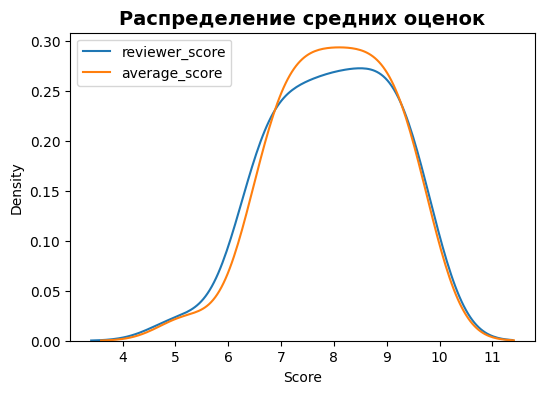

In [39]:
fig, (ax) = plt.subplots(figsize=(6, 4))

sns.kdeplot(train_data_score['reviewer_score'], ax=ax, label='reviewer_score')
sns.kdeplot(train_data_score['average_score'], ax=ax, label='average_score')
ax.set_title('Распределение средних оценок', fontweight='bold', fontsize=14)
ax.set_xlabel('Score')
ax.legend();

Исходя из графика распределения, можно предположить, что признаки распределены нормально. Проверим гипотезу о нормальности распределения обоих признаков с помощью критерия Шапиро-Уилка.

In [40]:
# определяем гипотезы для проверки
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

alpha = 0.05

_, p = shapiro(train_data_score['reviewer_score'])
print('reviewer_score p-value = %.3f' % p)
if p > alpha:
    print(H0, '\n')
else:
    print(Ha, '\n')


_, p = shapiro(train_data_score['average_score'])
print('average_score p-value = %.3f' % p)
if p > alpha:
    print(H0)
else:
    print(Ha)

reviewer_score p-value = 0.294
Данные распределены нормально 

average_score p-value = 0.599
Данные распределены нормально


Поскольку данные распределены нормально, посмотрим на корреляцию Пирсона

In [41]:
display(train_data_score.corr())

,average_score,reviewer_score
average_score,1.000000,0.998163
reviewer_score,0.998163,1.000000


Корреляция имеет очень сильную связь, следовательно, признаки имеют зависимость между собой, проверим эту гипотезу

In [42]:
# определяем гипотезы для проверки
H0 = 'Нет зависимости между средним баллом отеля и оценкой пользователя.'
Ha = 'Есть зависимость между средним баллом отеля и оценкой пользователя.'

corr, p = pearsonr(train_data_score['reviewer_score'], train_data_score['average_score'])

if p > alpha:
    print(f"{round(p, 2)} > {alpha}. Мы не можем отвергнуть нулевую гипотезу об отсутствии зависимости между признаками - {H0}")
else:
    print(f"{round(p, 2)} <= {alpha}. Мы отвергаем нулевую гипотезу об отсутствии зависимости между признаками - {Ha}")

0.0 <= 0.05. Мы отвергаем нулевую гипотезу об отсутствии зависимости между признаками - Есть зависимость между средним баллом отеля и оценкой пользователя.


С названием отеля никаких преобразований не проводилось, добавим его в список для удаления

In [43]:
drop_list.append('hotel_name')

### 5.5 Обработка национальности человека, оставившего отзыв

In [44]:
print(f'Количество уникальных национальностей: {data["reviewer_nationality"].nunique()}\n')

Количество уникальных национальностей: 227



Посмотрим на 10 самых часто встречающихся национальностей

In [45]:
display(data['reviewer_nationality'].value_counts().head(10))

reviewer_nationality
United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
Name: count, dtype: int64

**Проверим, является ли человек оставивший отзыв резидентом страны в котором находится этот отель**

In [46]:
resident = data[data['reviewer_nationality'] == data['country']]

if resident.shape[0] > 0:
    print(f'Количество резидентов: {resident.shape[0]} человек')
else:
    print('Резидентов не найдено')

Количество резидентов: 178403 человек


**Оставим только 10 наиболее часто встречающихся национальностей, остальные заменим на "other"**

In [47]:
# cоздаем список самых распространенных национальностей
more_common_nationality      = data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in more_common_nationality else 'Other')

**Выполним бинарное кодирование признака "Национальность рецензента"**

In [48]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin    = bin_encoder.fit_transform(data['reviewer_nationality'])
data        = pd.concat([data, type_bin], axis=1)

d:\virtual_environments\project_3_eda_and_feature_engineering\lib\site-packages\category_encoders\utils.py:27: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(cols):
d:\virtual_environments\project_3_eda_and_feature_engineering\lib\site-packages\category_encoders\utils.py:49: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
d:\virtual_environments\project_3_eda_and_feature_engineering\lib\site-packages\category_encoders\utils.py:49: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return pd.api.types.is_categorical_dtype(dtype)
d:\virtual_environments\project_3_eda_and_feature_engineering\lib\site-packages\category_encoders\util

In [49]:
reviewer_nationality_df = pd.concat([data['reviewer_nationality'].loc[:4], data.loc[:4, 'reviewer_nationality_0':]], axis=1)

display(reviewer_nationality_df)

,reviewer_nationality,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3
0,United Kingdom,0,0,0,1
1,Other,0,0,1,0
2,Other,0,0,1,0
3,United States of America,0,0,1,1
4,United Kingdom,0,0,0,1


Данные корректны, можно добавить признак **"reviewer_nationality"** в список для удаления

In [50]:
drop_list.append('reviewer_nationality')

### 5.6 Обработка отзывов

Посмотрим на негативные и позитивные отзывы

In [51]:
display(data['negative_review'].value_counts().reset_index().head())

,negative_review,count
0,No Negative,127890
1,Nothing,18531
2,nothing,2508
3,None,1166
4,N A,1060


In [52]:
display(data['positive_review'].value_counts().reset_index().head())

,positive_review,count
0,No Positive,35946
1,Location,10137
2,Everything,2897
3,location,1736
4,Nothing,1468


Переведем отзывы из текста, в числовое представление при помощи библиотеки **nltk**

In [53]:
nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dmitriy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [54]:
# получаем общую сводку по каждому отзыву во временные признаки
data['negative_score_summary'] = data['negative_review'].progress_apply(lambda x: sent_analyzer.polarity_scores(x))
data['positive_score_summary'] = data['positive_review'].progress_apply(lambda x: sent_analyzer.polarity_scores(x))

# выделяем информацию в отдельные признаки
data['negative_review_neg']      = data['negative_score_summary'].apply(lambda x: x['neg'])
data['negative_review_neu']      = data['negative_score_summary'].apply(lambda x: x['neu'])
data['negative_review_pos']      = data['negative_score_summary'].apply(lambda x: x['pos'])
data['negative_review_compound'] = data['negative_score_summary'].apply(lambda x: x['compound'])

data['positive_review_neg']      = data['positive_score_summary'].apply(lambda x: x['neg'])
data['positive_review_neu']      = data['positive_score_summary'].apply(lambda x: x['neu'])
data['positive_review_pos']      = data['positive_score_summary'].apply(lambda x: x['pos'])
data['positive_review_compound'] = data['positive_score_summary'].apply(lambda x: x['compound'])

  0%|          | 0/515738 [00:00<?, ?it/s]

  0%|          | 0/515738 [00:00<?, ?it/s]

Самым часто встречающимся негативным отзывом является **"No Negative"**, а среди положительных отзывов **"No Positive"**. Анализатор, воспринимает такие слова как негативный и позитивный, что является неверным в контексте данных отзывов, так как они несут как раз-таки обратный смысл.

Создадим дополнительные признаки, с пометкой о том, что отзыв, на самом деле не является негативным или позитивным.

In [55]:
data['no_negative'] = 0
data['no_positive'] = 0

# Исходя из анализа количества уникальных отзывов, 
# был составлен список для НЕ негативных отзывов
no_negative_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 
                    'nothing really', 'no complaints', 'nil', 'nothing at all', 
                    'na', 'nothing to dislike', 'liked everything', 'no', 
                    'can t think of anything', 'everything was perfect', 
                    'absolutely nothing', 'nothing to dislike', 'non', 
                    'everything was great', 'nothing to complain about']

data.loc[data['negative_review'].str.lower().str.strip().isin(no_negative_list), 'no_negative']     = 1
data.loc[data['negative_review'].str.lower().str.strip().isin(['everything']), 'no_positive']       = 1
data.loc[data['negative_review'].str.lower().str.strip().isin(no_negative_list), 'negative_review'] = ''

display(data['negative_review'].value_counts().head(10))

negative_review
                       158085
Small room                455
Breakfast                 449
Location                  421
Everything                367
Price                     301
Small rooms               245
Leaving                   220
Expensive                 181
Nothing not to like       175
Name: count, dtype: int64

In [56]:
no_positive_list = ['no positive', 'nothing']

data.loc[data['positive_review'].str.lower().str.strip().isin(no_positive_list), 'no_positive'] = 1
data.loc[data['positive_review'].str.lower().str.strip().isin(['everything']), 'no_negative']   = 1

display(data['positive_review'].value_counts().head(10))

positive_review
No Positive       35946
Location          10137
Everything         2897
location           1736
Nothing            1468
Great location     1419
The location       1341
Good location      1203
Breakfast           664
Friendly staff      603
Name: count, dtype: int64

Создадим признак с длиной отзыва (общим количеством символов)

In [57]:
data['negative_len'] = data['negative_review'].map(len)
data['positive_len'] = data['positive_review'].map(len)

In [58]:
# удалим временный признак
data = data.drop(['negative_score_summary', 'positive_score_summary'], axis=1)

display(data.loc[:, 'negative_review_neg':].head(3))

,negative_review_neg,negative_review_neu,negative_review_pos,negative_review_compound,positive_review_neg,positive_review_neu,positive_review_pos,positive_review_compound,no_negative,no_positive,negative_len,positive_len
0,0.129,0.747,0.125,-0.0554,0.000,0.671,0.329,0.9615,0,0,260,335
1,0.216,0.784,0.000,-0.2960,0.379,0.000,0.621,0.3400,0,1,43,11
2,0.000,1.000,0.000,0.0000,0.000,0.260,0.740,0.6908,0,0,7,26


**Посмотрим на количество положительных и отрицательных отзывов в зависимости от рейтинга отеля**

In [59]:
display(data.groupby('hotel_name')[['average_score', 
                                    'negative_review_compound', 
                                    'positive_review_compound']
                                   ]
        .mean()
        .reset_index()
        .sort_values(by='average_score', ascending=False)
        .head(3))

,hotel_name,average_score,negative_review_compound,positive_review_compound
1202,Ritz Paris,9.8,-0.250468,0.604157
3,41,9.6,-0.281250,0.667145
472,H tel de La Tamise Esprit de France,9.6,-0.196611,0.701998


Поскольку данные из таблицы согласуются с реальностью - чем выше средняя оценка отеля, тем больше положительных отзывов и меньше отрицательных, а при более низкой средней оценке отеля, наоборот, негативных отзывов становится больше. Исходя из этого, можно сделать вывод о том, что числовое выражение отзывов в целом корректно.

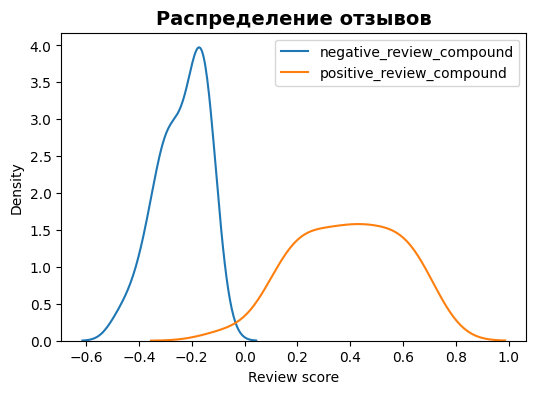

In [60]:
# создадим сводную таблицу со средними значениями отзывов для тренировочной выборки
train_data_review = data[data['sample']==1].pivot_table(
    values  = ['negative_review_compound', 'positive_review_compound'], 
    index   = 'reviewer_score', 
    aggfunc = 'mean').reset_index()

# построим график
fig, (ax) = plt.subplots(figsize=(6, 4))
ax.set_title('Распределение отзывов', fontweight='bold', fontsize=14)

sns.kdeplot(train_data_review['negative_review_compound'], ax=ax, label='negative_review_compound')
sns.kdeplot(train_data_review['positive_review_compound'], ax=ax, label='positive_review_compound')
ax.set_xlabel('Review score')
ax.legend();

In [61]:
# определяем гипотезы для проверки
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

alpha = 0.05

_, p = shapiro(train_data_review['negative_review_compound'])
print('negative_review_compound p-value = %.3f' % p)
if p > alpha:
    print(H0, '\n')
else:
    print(Ha, '\n')


_, p = shapiro(train_data_review['positive_review_compound'])
print('positive_review_compound p-value = %.3f' % p)
if p > alpha:
    print(H0)
else:
    print(Ha)

negative_review_compound p-value = 0.047
Данные не распределены нормально (мы отвергаем H0) 

positive_review_compound p-value = 0.385
Данные распределены нормально


Поскольку данные не распределены нормально, посмотрим на корреляцию Спирмена

In [62]:
display(train_data_review.corr(method='spearman'))

,reviewer_score,negative_review_compound,positive_review_compound
reviewer_score,1.000000,0.662873,0.984590
negative_review_compound,0.662873,1.000000,0.662162
positive_review_compound,0.984590,0.662162,1.000000


In [63]:
# определяем гипотезы для проверки
H0 = 'Нет зависимости между негативным отзывом и оценкой пользователя.'
Ha = 'Есть зависимость между негативным отзывом и оценкой пользователя.'

corr, p = spearmanr(
    train_data_review['reviewer_score'], 
    train_data_review['negative_review_compound'])

if p > alpha:
    print(f"{round(p, 2)} > {alpha}. Мы не можем отвергнуть нулевую гипотезу об отсутствии зависимости между признаками - {H0}")
else:
    print(f"{round(p, 2)} <= {alpha}. Мы отвергаем нулевую гипотезу об отсутствии зависимости между признаками - {Ha}")

0.0 <= 0.05. Мы отвергаем нулевую гипотезу об отсутствии зависимости между признаками - Есть зависимость между негативным отзывом и оценкой пользователя.


In [64]:
# определяем гипотезы для проверки
H0 = 'Нет зависимости между позитивным отзывом и оценкой пользователя.'
Ha = 'Есть зависимость между позитивным отзывом и оценкой пользователя.'

corr, p = spearmanr(
    train_data_review['reviewer_score'], 
    train_data_review['positive_review_compound'])

if p > alpha:
    print(f"{round(p, 2)} > {alpha}. Мы не можем отвергнуть нулевую гипотезу об отсутствии зависимости между признаками - {H0}")
else:
    print(f"{round(p, 2)} <= {alpha}. Мы отвергаем нулевую гипотезу об отсутствии зависимости между признаками - {Ha}")

0.0 <= 0.05. Мы отвергаем нулевую гипотезу об отсутствии зависимости между признаками - Есть зависимость между позитивным отзывом и оценкой пользователя.


Средняя оценка отзывов имеет прямую связь со средней оценкой пользователя, которая, в свою очередь взаимосвязана с оценкой отеля за последний год. Это говорит о том, что признак **average_score** имеет высокую значимость для обучения модели.

### 5.7 Обработка количества слов в отзывах

Проверим, соответствует ли количество слов в признаках **review_total_negative_word_counts** и **review_total_positive_word_counts** реальному количеству слов в отзывах

In [65]:
display(data[['negative_review', 
              'review_total_negative_word_counts', 
              'positive_review', 
              'review_total_positive_word_counts']].head(3))

,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts
0,Would have appreciated a shop in the hotel tha...,52,Hotel was great clean friendly staff free brea...,62
1,No tissue paper box was present at the room,10,No Positive,0
2,Pillows,3,Nice welcoming and service,5


Количество слов не соответствует действительности, исправим это

In [66]:
data['review_total_negative_word_counts'] = data['negative_review'].apply(lambda x: len(x.split()))
data['review_total_positive_word_counts'] = data['positive_review'].apply(lambda x: len(x.split()))

display(data[['negative_review', 
              'review_total_negative_word_counts', 
              'positive_review', 
              'review_total_positive_word_counts']].head(3))

,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts
0,Would have appreciated a shop in the hotel tha...,50,Hotel was great clean friendly staff free brea...,60
1,No tissue paper box was present at the room,9,No Positive,2
2,Pillows,1,Nice welcoming and service,4


Теперь всё правильно, можно добавлять признаки **negative_review** и **positive_review** в список для удаления

In [67]:
drop_list.extend(['negative_review', 'positive_review'])

**Проверим, как влияет положительный или отрицательный отзыв на количество написанных слов**

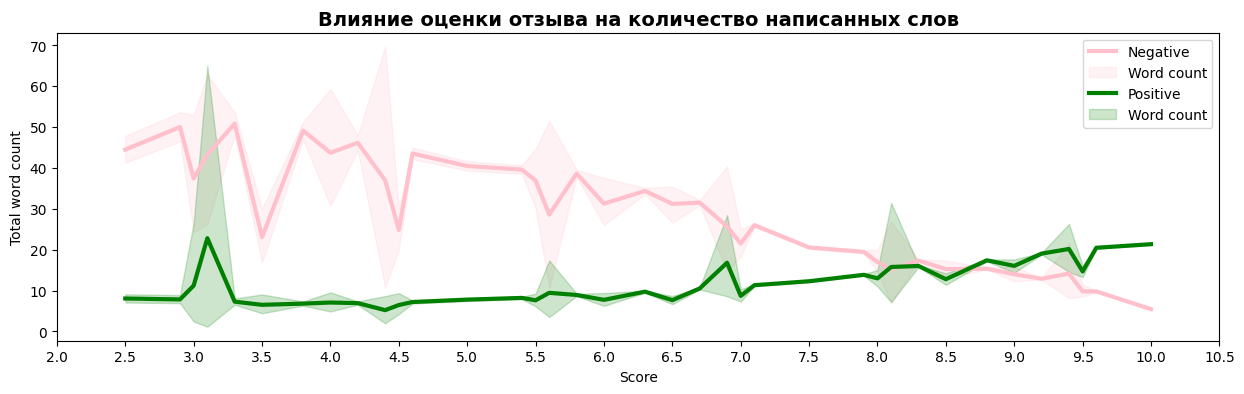

In [68]:
fig, axes = plt.subplots(figsize=(15, 4))

sns.lineplot(
    data  = data[data['sample']==1],
    x     = 'reviewer_score',
    y     = 'review_total_negative_word_counts',
    color = 'pink', linewidth=3,
    ax    = axes
)
sns.lineplot(
    data  = data[data['sample']==1],
    x     = 'reviewer_score',
    y     = 'review_total_positive_word_counts',
    color = 'green', linewidth=3,
    ax    = axes
)
axes.set_title('Влияние оценки отзыва на количество написанных слов', fontweight='bold', size=14)
axes.set_xlabel('Score')
axes.set_ylabel('Total word count')
axes.set_xticks(np.arange(2, 11, 0.5))
axes.legend(['Negative', 'Word count', 'Positive', 'Word count'], loc='upper right');

Как видно из графика, чем ниже оценка за негативный отзыв, тем больше слов употребляют при его написании, по всей видимости в подробностях описывая свой негативный опыт. С увеличением оценки за негативный отзыв, количество слов сильно снижается, что может говорить о большей солидарности по отношению к отелю и персоналу. В отзыве пишут только самую суть, короткими, ближе к нейтральным, словами, отражая недостатки, без эмоций. В то время как при низкой оценке за положительный отзыв, люди скорее всего склонны писать односложные слова или короткие предложения, из разряда - всё здорово, понравилось, ок и т.п., не особо заморачиваясь с написанием подробного отзыва. С увеличением оценки за положительный отзыв, клиенты склонны к более развернутому описанию, возможно рассказывая о своих впечатлениях и эмоциях.

**Создадим новые признаки**

Посчитаем разницу количества слов в положительных отзывах от общего числа слов в положительных и отрицательных отзывах

In [69]:
sum_reviews = data['review_total_positive_word_counts'] + data['review_total_negative_word_counts']

data['pos_words_count_diff'] = data['review_total_positive_word_counts'] / sum_reviews
data['neg_words_count_diff'] = data['review_total_negative_word_counts'] / sum_reviews

Посчитаем разницу положительных и отрицательных отзывов от общего числа отзывов, сделанных рецензентом

In [70]:
data['pos_words_count_per_review'] = data['review_total_positive_word_counts'] / data['total_number_of_reviews_reviewer_has_given']
data['neg_words_count_per_review'] = data['review_total_negative_word_counts'] / data['total_number_of_reviews_reviewer_has_given']


display(data[['review_total_positive_word_counts', 'review_total_negative_word_counts', 
              'pos_words_count_diff', 'neg_words_count_diff', 'pos_words_count_per_review', 
              'neg_words_count_per_review'
              ]].head(3))

,review_total_positive_word_counts,review_total_negative_word_counts,pos_words_count_diff,neg_words_count_diff,pos_words_count_per_review,neg_words_count_per_review
0,60,50,0.545455,0.454545,60.000000,50.000000
1,2,9,0.181818,0.818182,0.285714,1.285714
2,4,1,0.800000,0.200000,0.266667,0.066667


In [71]:
print(f'Количество пропусков "pos_words_count_diff": {data[data["pos_words_count_diff"].isna()].shape[0]}')
print(f'Количество пропусков "neg_words_count_diff": {data[data["neg_words_count_diff"].isna()].shape[0]}')
print(f'Количество пропусков "pos_words_count_per_review": {data[data["pos_words_count_per_review"].isna()].shape[0]}')
print(f'Количество пропусков "neg_words_count_per_review": {data[data["neg_words_count_per_review"].isna()].shape[0]}')

Количество пропусков "pos_words_count_diff": 95
Количество пропусков "neg_words_count_diff": 95
Количество пропусков "pos_words_count_per_review": 0
Количество пропусков "neg_words_count_per_review": 0


Поскольку пропусков немного, заменим их медианным значением

In [72]:
data['pos_words_count_diff'] = data['pos_words_count_diff'].fillna(data['pos_words_count_diff'].median())
data['neg_words_count_diff'] = data['neg_words_count_diff'].fillna(data['neg_words_count_diff'].median())


print(f'Количество пропусков "pos_words_count_diff": {data[data["pos_words_count_diff"].isna()].shape[0]}')

Количество пропусков "pos_words_count_diff": 0


### 5.8 Обработка тегов

Создадим словарь, в котором будут только уникальные теги и их количество

In [73]:
tags_dict = {}

for i, row in data['tags'].items():
    tmp = row.replace("[' ", "").replace(" ']", '')
    tmp = tmp.split(" ', ' ")
    for el in tmp:
        if el not in tags_dict:
            tags_dict[el] = 1
        else:
            tags_dict[el] += 1

# cоздадим датафрейм с тегами из словаря
tags_df = pd.DataFrame.from_dict(tags_dict, orient='index', columns=['count'])

print(f'Количество уникальных тегов: {tags_df.shape[0]}')

Количество уникальных тегов: 2428


**Посмотрим на самые популярные теги**

In [74]:
display(tags_df.sort_values(by='count', ascending=False).head())

,count
Leisure trip,417778
Submitted from a mobile device,307640
Couple,252294
Stayed 1 night,193645
Stayed 2 nights,133937


**Проведем очистку тегов от неверного форматирования и приведем их к виду списка**

In [75]:
data['tags'] = data['tags'].apply(clean_tags)

# cоздадим список, из часто встречающихся тегов
favorite_tags = tags_df.sort_values(by='count', ascending=False).head(20).index

print(favorite_tags)

Index(['Leisure trip', 'Submitted from a mobile device', 'Couple',
       'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights',
       'Business trip', 'Group', 'Family with young children',
       'Stayed 4 nights', 'Double Room', 'Standard Double Room',
       'Superior Double Room', 'Family with older children',
       'Deluxe Double Room', 'Double or Twin Room', 'Stayed 5 nights',
       'Standard Double or Twin Room', 'Classic Double Room'],
      dtype='object')


**Создадим новые признаки**

Список был составлен путем анализа списка наиболее часто встречающихся тегов, в который были добавлены наиболее интересные на мой взгляд теги

In [76]:
favorite_tags = ['Leisure trip', 'Submitted from a mobile device', 'Couple',
                 'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 
                 'Stayed 3 nights', 'Business trip', 'Group', 'Executive Room', 
                 'Family with young children', 'Stayed 4 nights', 'Double Room', 
                 'Standard Double Room', 'Superior Double Room', 'Queen Room', 
                 'Family with older children', 'Deluxe Double Room', 
                 'Double or Twin Room', 'Stayed 5 nights', 'Triple Room', 
                 'Standard Double or Twin Room', 'Classic Double Room', 
                 'Twin Room', 'Ambassador Junior Suite', 'Standard Triple Room',
                 'Classic Double or Twin Room']

Создаем новые признаки из списка favorite_tags

In [77]:
for tag in favorite_tags:
    tag_col = tag.lower().replace(' ', '_')
    data[tag_col] = data['tags'].apply(lambda x: 1 if tag in x else 0)

Извлекаем в отдельный признак количество ночей, проведенных в отеле

In [78]:
data['nights_spent'] = data['tags'].apply(get_number_of_nights)

In [79]:
print(f'Количество пропусков: {data[data["nights_spent"].isna()].shape[0]}')
print(f'Самое часто встречающееся значение: {data["nights_spent"].mode()[0]}')

Количество пропусков: 192
Самое часто встречающееся значение: 1


In [80]:
# заполняем отсутствующие значения на 1
data['nights_spent'] = data['nights_spent'].fillna(1)

data['nights_spent'] = data['nights_spent'].astype('float64')

display(data.loc[:,'leisure_trip':].head(3))

,leisure_trip,submitted_from_a_mobile_device,couple,stayed_1_night,stayed_2_nights,solo_traveler,stayed_3_nights,business_trip,group,executive_room,...,double_or_twin_room,stayed_5_nights,triple_room,standard_double_or_twin_room,classic_double_room,twin_room,ambassador_junior_suite,standard_triple_room,classic_double_or_twin_room,nights_spent
0,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.0
1,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1.0
2,0,1,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1.0


Данные извлечены корректно, можно добавлять признак **tags** в список для удаления

In [81]:
drop_list.append('tags')

### 5.9 Обработка признака days_since_review

Приведение признака "days_since_review" к числовому типу

In [82]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int')

display(data[['nights_spent', 'days_since_review']].head())

,nights_spent,days_since_review
0,2.0,13
1,1.0,234
2,1.0,616
3,1.0,656
4,2.0,444


[&#8679; к оглавлению](#Оглавление:)

## 6 Определение неинформативных признаков

In [83]:
# создадим список из названий числовых признаков
num_columns = [s for s in data.columns if data[s].dtypes != 'object']
num_columns.remove('review_date')

# список неинформативных признаков
low_information_cols = [] 

for col in num_columns:
    top_freq = data[col].value_counts(normalize=True).max()
    nunique_ratio = data[col].nunique() / data[col].count()
    
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

duplicates: 	99.93% одинаковых значений
executive_room: 	99.75% одинаковых значений
queen_room: 	98.94% одинаковых значений
deluxe_double_room: 	95.19% одинаковых значений
double_or_twin_room: 	95.66% одинаковых значений
stayed_5_nights: 	95.96% одинаковых значений
triple_room: 	99.13% одинаковых значений
standard_double_or_twin_room: 	96.61% одинаковых значений
classic_double_room: 	96.71% одинаковых значений
twin_room: 	98.39% одинаковых значений
ambassador_junior_suite: 	100.0% одинаковых значений
standard_triple_room: 	99.75% одинаковых значений
classic_double_or_twin_room: 	98.82% одинаковых значений


В данных присутствует много неинформативных признаков, обработаем их при анализе мультиколлениарности.

Признаки **duplicates** и нельзя считать неинформативными, в виду особенности их заполнения. В целом можно сделать вывод, что неинформативных признаков в датасете нет.

[&#8679; к оглавлению](#Оглавление:)

## 7 Отбор признаков

Удалим ненужные признаки

In [84]:
data = data.drop(drop_list, axis=1)

**Разделим признаки на числовые и категориальные, для более легкого анализа признаков**

In [85]:
# числовые признаки
num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts',
            'total_number_of_reviews', 'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given', 'days_since_review',
            'country_population', 'сity_population', 'population_diff',
            'pos_words_count_diff', 'neg_words_count_diff', 'negative_len',
            'pos_words_count_per_review', 'neg_words_count_per_review',
            'negative_review_neg', 'negative_review_neu', 'negative_review_pos', 
            'negative_review_compound', 'positive_review_neg', 'positive_len',
            'positive_review_neu', 'positive_review_pos', 
            'positive_review_compound']


# категориальные признаки
cat_cols = ['average_score', 'lat', 'lng', 'twin_room', 'executive_room',
            'italy', 'netherlands', 'spain','ambassador_junior_suite', 'group',
            'united_kingdom', 'france','austria', 'classic_double_or_twin_room',
            'milan', 'amsterdam', 'barcelona', 'london', 'queen_room', 'couple',
            'paris', 'vienna', 'triple_room', 'standard_triple_room', 'double_room',
            'leisure_trip', 'stayed_2_nights', 'stayed_1_night', 'business_trip', 
            'solo_traveler', 'submitted_from_a_mobile_device', 'superior_double_room',
            'standard_double_or_twin_room', 'stayed_3_nights', 'double_or_twin_room', 
            'duplicates', 'review_month', 'reviewer_nationality_0', 'no_negative', 
            'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 
            'no_positive', 'family_with_young_children', 'stayed_4_nights', 
            'standard_double_room', 'family_with_older_children', 'deluxe_double_room', 
            'stayed_5_nights', 'classic_double_room', 'nights_spent']

[&#8679; к оглавлению](#Оглавление:)

## 8 Проверка на мультиколлинеарность

### 8.1 Анализ числовых признаков

**Построим на тепловую карту корреляции признаков для выявления сильно скоррелированных признаков. Это поможет уменьшить количество признаков и улучшить качество предсказания модели.**

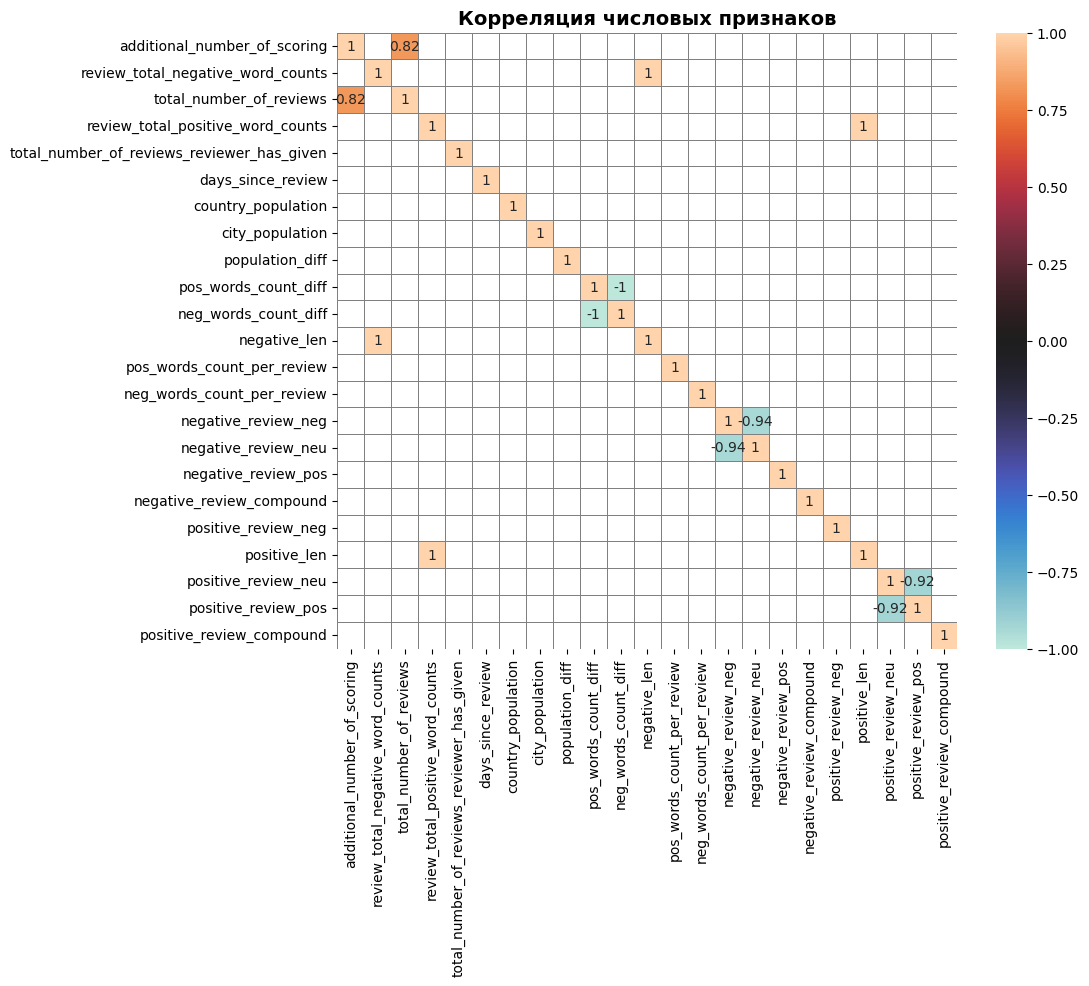

In [86]:
corr = data[num_cols].corr()
corr = corr[np.abs(corr) >= 0.8]

plt.subplots(figsize=(10,8))
heatmap = sns.heatmap(
    corr, 
    annot      = True, 
    linewidths = 0.5, 
    vmin       = -1, 
    vmax       = 1, 
    center     = 0, 
    linecolor  = 'grey')
heatmap.set_title('Корреляция числовых признаков', fontweight='bold', size=14);

### 8.2 Анализ категориальных признаков

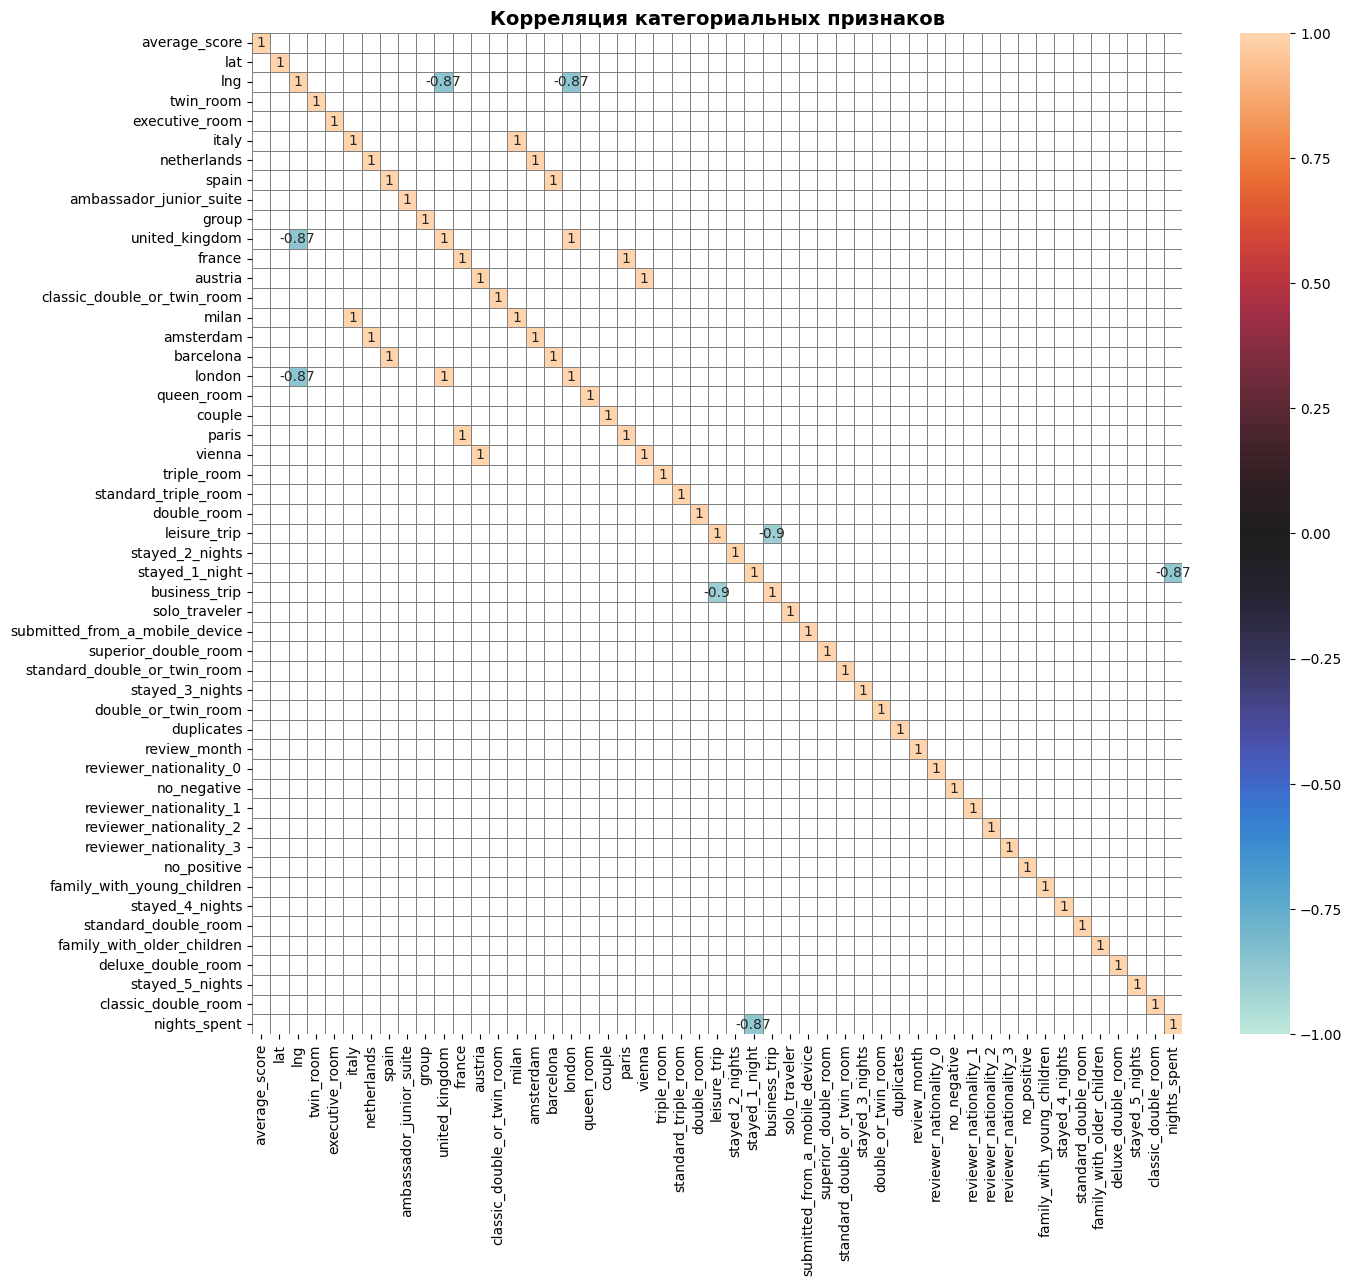

In [87]:
corr = data[cat_cols].corr(method='spearman')
corr = corr[np.abs(corr) >= 0.8]

plt.subplots(figsize=(15,13))
heatmap = sns.heatmap(
    corr, 
    annot      = True, 
    linewidths = 0.5, 
    vmin       = -1, 
    vmax       = 1, 
    center     = 0, 
    linecolor  = 'grey')
heatmap.set_title('Корреляция категориальных признаков', fontweight='bold', size=14);

### 8.3 Оценка значимости признаков

**Выполним непараметрический тест хи-квадрат для оценки значимости категориальных переменных**

In [88]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

X['lng_'] = X['lng'] - X['lng'].min()
X         = X.drop(['lng'], axis=1)

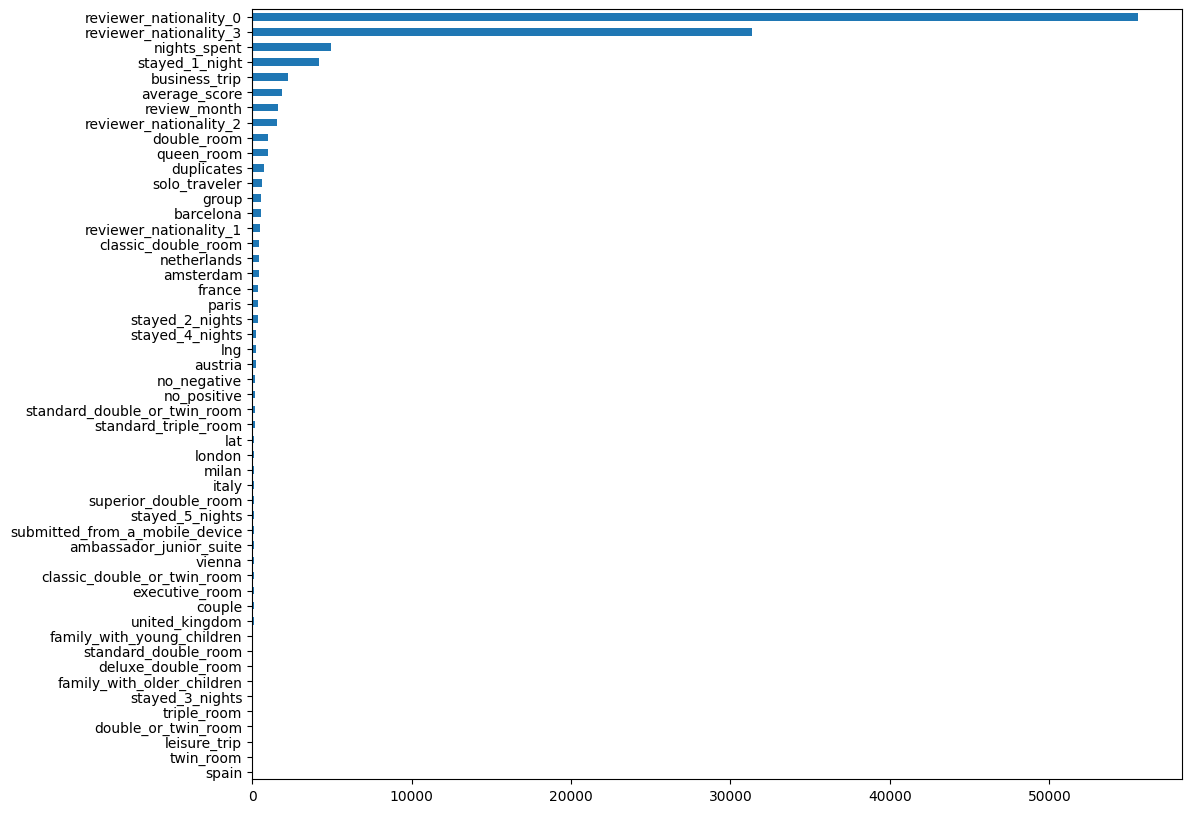

In [89]:
plt.rcParams['figure.figsize'] = (12, 10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

**Выполним ANOVA тест для оценки значимости числовых переменных**

In [90]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

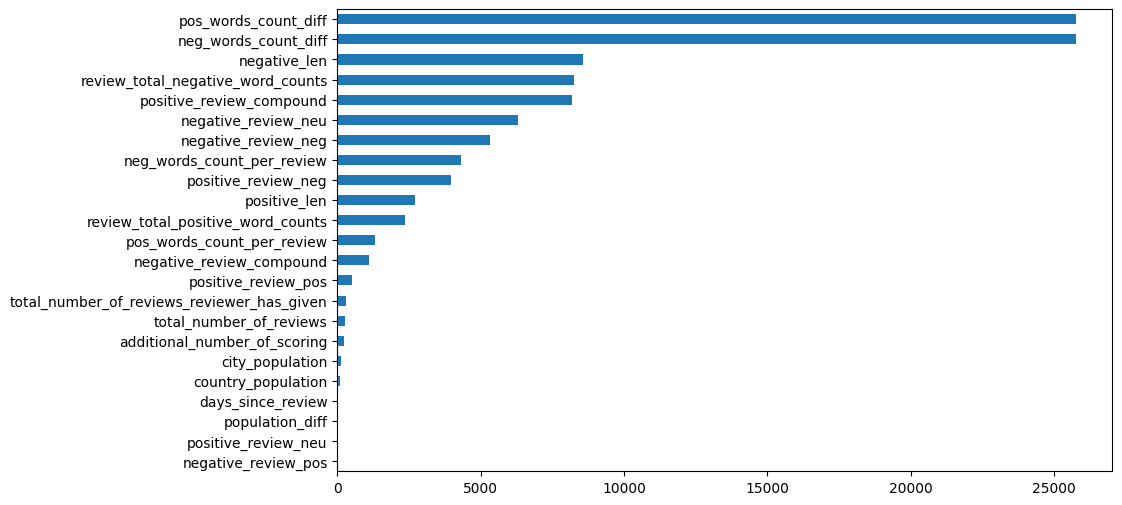

In [91]:
plt.rcParams['figure.figsize'] = (10, 6)
imp_num = pd.Series(f_classif(X, y)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh');

В данных присутсвует достаточно большое число сильно скоррелированных признаков, необходимо их удалить, для улучшения качества предсказания модели.

In [92]:
# чтобы исключить мультиколлениарность, удалим сильно коррелирующие признаками
pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.72 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

# постараемся удалить минимальное количество признаков - удаляем признаки с максимальной корреляцией
print('Признаки, которые были удалены:')
counter = 0
for lower_bound in np.linspace(0.98, 0.72, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            print(col)
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data  = data.drop(col, axis=1)
            counter += 1


Признаки, которые были удалены:
review_total_negative_word_counts
review_total_positive_word_counts
united_kingdom
london
pos_words_count_diff
negative_review_neg
positive_review_neu
leisure_trip
positive_review_neg
lat
additional_number_of_scoring
lng
no_negative


**Подготовка и обучение модели**

In [93]:
# выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data  = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

# разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
print(test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape)

(128935, 62) (386803, 62) (386803, 61) (309442, 61) (77361, 61)


In [94]:
# создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# используем обученную модель для предсказания рейтинга
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.3s finished


In [95]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.8607213324543371


**Посмотрим на самые важные признаки для модели**

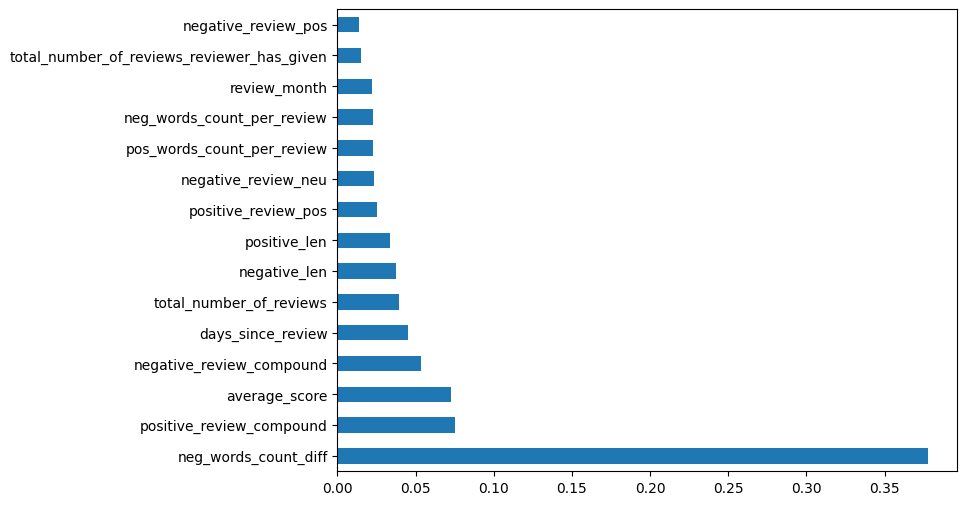

In [96]:
plt.rcParams['figure.figsize'] = (8, 6)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [97]:
test_data.sample(3)

,average_score,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,days_since_review,reviewer_score,duplicates,italy,netherlands,spain,france,...,double_or_twin_room,stayed_5_nights,triple_room,standard_double_or_twin_room,classic_double_room,twin_room,ambassador_junior_suite,standard_triple_room,classic_double_or_twin_room,nights_spent
92273,8.4,1374,1,101,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.0
88159,8.0,1053,2,21,0.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.0
55790,9.0,1974,1,398,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


In [98]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [99]:
display(sample_submission)

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [100]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.2s finished


In [101]:
display(predict_submission)

array([8.651, 7.079, 8.352, ..., 8.048, 9.678, 7.173])

In [102]:
print(list(sample_submission))

['reviewer_score', 'id']


In [103]:
sample_submission['reviewer_score'] = predict_submission

sample_submission.to_csv('submission.csv', index=False)

display(sample_submission.head(10))

,reviewer_score,id
0,8.651,488440
1,7.079,274649
2,8.352,374688
3,9.737,404352
4,9.553,451596
5,8.926,302161
6,7.865,317079
7,7.496,13963
8,8.411,159785
9,7.357,195089


[&#8679; к оглавлению](#Оглавление:)